In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [9]:
train_imgs = torchvision.datasets.ImageFolder('hotdog/train/')
test_imgs = torchvision.datasets.ImageFolder('hotdog/test/')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021D18C15EB8>,
      dtype=object)

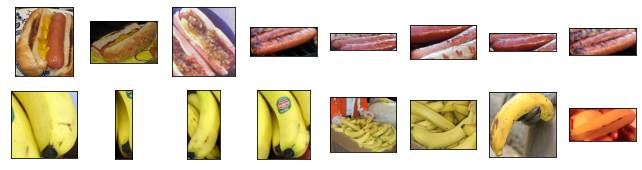

In [11]:
# 下面显示了前8个正类样本图片和最后8张负类样本图片。正如所看到的，图像的大小和纵横比各有不同。
hotdogs = [train_imgs[i][0] for i in range(8)]
non_hotdogs = [test_imgs[-1-i][0] for i in range(8)]
d2l.show_images(hotdogs + non_hotdogs, 2, 8, scale=1.4)

In [12]:
# 对于RGB（红、绿和蓝）颜色通道，我们分别标准化每个通道。 具体而言，该通道的每个值减去该通道的平均值，然后将结果除以该通道的标准差。
# 均值和方差是事先计算所得到的，左边是均值，右边是方差
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
)
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize
])

In [13]:
# 我们首先来看一下什么是预训练模型，在这里，我们指定pretrained=True以自动下载预训练的模型参数。 如果首次使用此模型，则需要连接互联网才能下载。
pretrained_net = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\15349816070/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


In [14]:
# 预训练的源模型实例包含许多特征层和一个输出层fc。 此划分的主要目的是促进对除输出层以外所有层的模型参数进行微调。 下面给出了源模型的成员变量fc。
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [15]:
# 在ResNet的全局平均汇聚层后，全连接层转换为ImageNet数据集的1000个类输出。 之后，我们构建一个新的神经网络作为目标模型。 它的定义方式与预训练源模型的定义方式相同，只是最终层中的输出数量被设置为目标数据集中的类数（而不是1000个）。
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[ 0.0264, -0.0976, -0.0018,  ..., -0.0541,  0.0178, -0.0343],
        [ 0.0719, -0.0244,  0.0486,  ..., -0.0160,  0.0489,  0.0119]],
       requires_grad=True)

In [16]:
# 首先，我们定义了一个训练函数train_fine_tuning，该函数使用微调，因此可以多次调用。
# 全连接层当中的参数是随机初始化的，通常需要更高的学习率才能从头开始训练。 假设Trainer实例中的学习率为λ，我们将成员变量output中参的学习率设置为10*λ。
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('hotdog/train/', transform=train_augs), batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('hotdog/test/', transform=test_augs), batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction='none')
    if param_group:
        param_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': param_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

KeyboardInterrupt: 

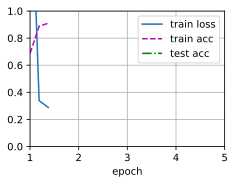

In [17]:
train_fine_tuning(finetune_net, 5e-5)

# 跑的速度实在是太慢，于是我采用GPU跑，附上结果图：
![](images/image26.jpg)

In [ ]:
# 为了进行比较，我们定义了一个相同的模型，但是将其所有模型参数初始化为随机值。 由于整个模型需要从头开始训练，因此我们需要使用更大的学习率。
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

# 跑的速度实在是太慢，于是我采用GPU跑，附上结果图：
![](images/image27.jpg)

# 意料之中，微调模型往往表现更好，因为它的初始参数值更有效。